## NIMOハンズオン (関数の最適化)

In [1]:
import sys
sys.path.append('..')
import nimo

### AIとロボットのサイクルの回数を設定

In [2]:
CyclesNum = 15

### 目的関数の次元を設定

In [3]:
ObjectivesNum = 1

In [4]:
from al_mg_zn import AlMgZnMeltingPoint
des = AlMgZnMeltingPoint()

### 実験条件候補データファイル名および提案条件のファイル名を設定

In [5]:
from pathlib import Path
TRIAL = 3
BATCH_SIZE = 3
NTS_MODE = "aggressive"
if NTS_MODE == "conservative":
    MODE = nimo.Mode.conservative
elif NTS_MODE == "moderate":
    MODE = nimo.Mode.moderate
elif NTS_MODE == "aggressive":
    MODE = nimo.Mode.aggressive
print(MODE)
out_dir = Path(f"./data_{NTS_MODE}_{TRIAL}")
out_dir.mkdir(exist_ok=True, parents=True)
Path(f"./data_{NTS_MODE}_{TRIAL}/fig").mkdir(exist_ok=True, parents=True)

Mode.aggressive


In [6]:
candidates_file = f"./mp_search_space_nts_{NTS_MODE}_{TRIAL}.csv"

proposals_file = f"./mp_proposals_nts_{NTS_MODE}_{TRIAL}.csv"

### 結果を格納する場所を作成

In [7]:
res_history = nimo.history(input_file = candidates_file,
                             num_objectives = ObjectivesNum)

### 最適化計算

In [ ]:
import time
start = time.time()
for K in range(CyclesNum):

    #最初のサイクルではランダムに実験条件を提案させる
    if K == 0:
        nimo.selection(method = "RE",
                       input_file = candidates_file,
                       output_file = proposals_file,
                       num_objectives = ObjectivesNum,
                       num_proposals = BATCH_SIZE,
                       re_seed = 111)

    #2回目以降のサイクルではAIを使用して実験条件を提案
    #PHYSBO: ベイズ最適化
    #BLOX: 無目的探索
    #PDC: 相図探索
    #RE: ランダム
    else:
        nimo.selection(method = "NTS",
                       input_file = candidates_file,
                       output_file = proposals_file,
                       num_objectives = ObjectivesNum,
                       num_proposals = BATCH_SIZE,
                       sample_mode=MODE,
                       use_dpp=False,
                       output_res=True)

    #実験条件に従い，ロボット実験のインプットファイルを作成する
    #今回は，inputfile.txtファイルを作成するだけのモジュール
    import preparation_input_functions
    preparation_input_functions.ORIGINAL(input_file = proposals_file,
                                         input_folder = "./").perform()


    #実験終了後，測定データを解析し，目的関数をアップデートする
    #今回は，関数値を計算し，目的関数とするanalysis_output_functions.pyを利用する
    import analysis_output_functions_SO_melting_point
    analysis_output_functions_SO_melting_point.ORIGINAL(input_file = proposals_file,
                                       output_file = candidates_file,
                                       num_objectives = ObjectivesNum,
                                       output_folder = f"./data_{NTS_MODE}_{TRIAL}").perform()

    #結果をプロットするためのhistoryを格納する
    res_history = nimo.history(input_file = candidates_file,
                               num_objectives = ObjectivesNum,
                               itt = K,
                               history_file = res_history)

    #結果のヒストグラムを作成するモジュールを読み出す
    if K % 5 == 0:
        import time
        time.sleep(1)
        nimo.visualization.plot_distribution.plot(input_file = candidates_file,
                                                  num_objectives = ObjectivesNum,
                                                  fig_folder = f"./data_{NTS_MODE}_{TRIAL}/fig")

    #結果の相図を作成するモジュールを読み出す
    #if K % 5 == 0:
    #    import time
    #    time.sleep(1)
    #    nimo.visualization.plot_phase_diagram.plot(input_file = candidates_file,
    #                                               fig_folder = "./fig")
end = time.time()
print(f"Elapsed time: {end - start} [s]")

Start selection of proposals by RE!
Proposals
###
number = 1
actions =  435
proposal =  [18. 24.]
###
###
number = 2
actions =  647
proposal =  [28. 48.]
###
###
number = 3
actions =  1011
proposal =  [52. 20.]
###
###
number = 4
actions =  397
proposal =  [16. 34.]
###
###
number = 5
actions =  814
proposal =  [38. 32.]
###
###
number = 6
actions =  853
proposal =  [40. 46.]
###
###
number = 7
actions =  1263
proposal =  [80.  6.]
###
Finish selection of proposals!
Start preparation input!
Finish preparation input!
Start analysis output!
Finish analysis output!
Start selection of proposals by NTS!
lstar: 854.587
reducing lstar
Selected actions: [672, 561, 1322]
Proposals
###
number = 1
actions =  672
proposal =  [30. 24.]
###
###
number = 2
actions =  561
proposal =  [24. 30.]
###
###
number = 3
actions =  1322
proposal =  [96.  4.]
###
Finish selection of proposals!
Start preparation input!
Finish preparation input!
Start analysis output!
Finish analysis output!
Start selection of pr

### 目的関数の推移を出力

In [9]:
nimo.visualization.plot_history.cycle(input_file = res_history,
                                      num_cycles = CyclesNum,
                                      fig_folder = f"./data_{NTS_MODE}_{TRIAL}/fig")

In [10]:
import numpy as np
tmp = []
X_tmp = []
for r in res_history:
    tmp.append(r[2][0])
    X_tmp.append(r[1])

tmp = np.array(tmp)
X_tmp = np.array(X_tmp)

In [11]:
from collections import defaultdict
sample_by_iter, objective_by_iter = defaultdict(list), defaultdict(list)
for r in res_history:
    objective_by_iter[r[0]].append(r[2][0])
    sample_by_iter[r[0]].append(r[1])

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])


Text(0, 0.5, 'Objective')

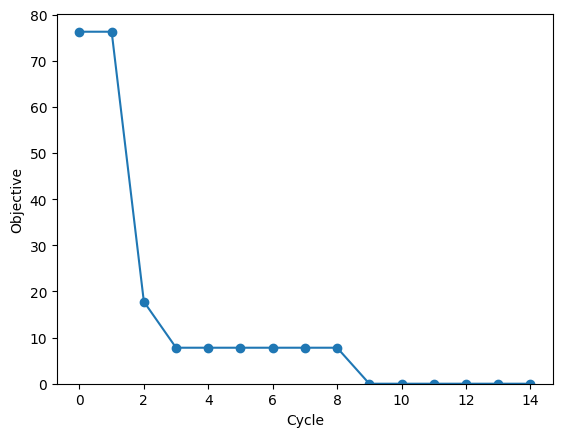

In [12]:
import matplotlib.pyplot as plt

print(objective_by_iter.keys())

fig, ax = plt.subplots()
tmp_history = [des.get_regret(max(objective_by_iter[1]))]
for i in range(1, CyclesNum):
    tmp_history.append(min(tmp_history[-1], des.get_regret(max(objective_by_iter[i]))))
ax.plot(range(CyclesNum), tmp_history, marker="o")
ax.set_xlabel("Cycle")
ax.set_ylim(0)
ax.set_ylabel("Objective")

In [13]:
# Save nested list object
import pickle
with open(out_dir / "objective_by_iter.pkl", "wb") as f:
    pickle.dump(objective_by_iter, f)
with open(out_dir / "sample_by_iter.pkl", "wb") as f:
    pickle.dump(sample_by_iter, f)